# Q5: Analysis (20 points)
By now you should know how to train networks from scratch or using from pre-trained models. You should also understand the relative performance in either scenarios. Needless to say, the performance of these models is stronger than previous non-deep architectures used until 2012. However, final performance is not the only metric we care about. It is important to get some intuition of what these models are really learning. Lets try some standard techniques.


**FEEL FREE TO WRITE UTIL CODE IN ANOTHER FILE AND IMPORT IN THIS NOTEBOOK FOR EASE OF READABILITY**

## 5.1 Nearest Neighbors (7 pts)
Pick 3 images from PASCAL test set from different classes, and compute 4 nearest neighbors over the entire test set for each of them. You should compare the following feature representations to find the nearest neighbors:
1. The features before the final fc layer from the ResNet (finetuned from ImageNet). It is the features right before the final class label output.
2. pool5 features from the CaffeNet (trained from scratch)

You may use the [this nearest neighbor function](https://scikit-learn.org/stable/modules/neighbors.html).
Plot the raw images of the ones you picked and their nearest neighbors.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
from sklearn.neighbors import NearestNeighbors

import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset
import nbimporter
from q5_utils import generate_rand, calculate_features, find_neighbors, plot_metrics, \
                     show_image, find_caffenet_features, plot_features, test_metrics
from sklearn.manifold import TSNE

In [2]:

# Load all the test images. Pick 3 indices.
test_loader = VOCDataset('test', 224)
req_three_idx = generate_rand(test_loader.index_list, test_loader.anno_list)

total_resnet_features = np.zeros((0, 512), dtype=np.float32)
total_caffenet_features = np.zeros((0, 6400), dtype=np.float32)
batch_size = 256

# Calculate the features for all the test images.
total_resnet_features, total_caffenet_features = calculate_features(test_loader)

# Fine the nearest neighbors for the 3 images you picked.
resnet_neighbor_indices = find_neighbors(total_resnet_features, req_three_idx)
caffenet_neighbor_indices = find_neighbors(total_caffenet_features, req_three_idx)

### ResNet Neighbours


 --- NEW CLASS ---
Original Image
Image classes are
bottle
person


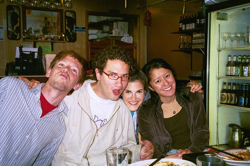

Neigbour:  1
Image classes are
chair
diningtable
person


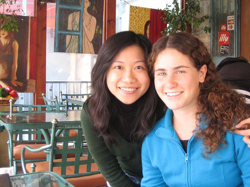

Neigbour:  2
Image classes are
person


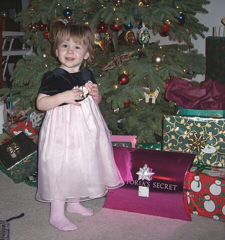

Neigbour:  3
Image classes are
person
pottedplant


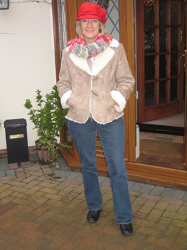

Neigbour:  4
Image classes are
chair
diningtable
person


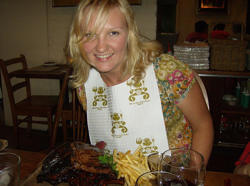

Neigbour:  5

 --- NEW CLASS ---
Original Image
Image classes are
aeroplane
bus


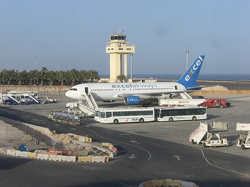

Neigbour:  1
Image classes are
aeroplane
person


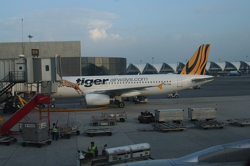

Neigbour:  2
Image classes are
boat


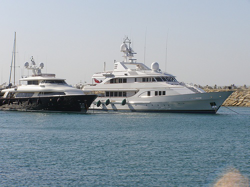

Neigbour:  3
Image classes are
aeroplane


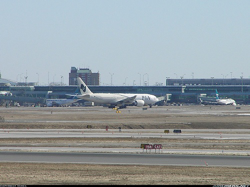

Neigbour:  4
Image classes are
aeroplane


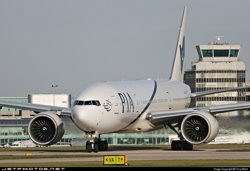

Neigbour:  5

 --- NEW CLASS ---
Original Image
Image classes are
dog


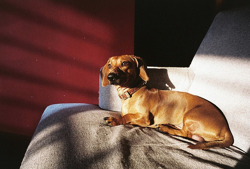

Neigbour:  1
Image classes are
dog


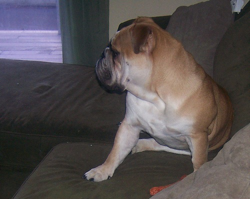

Neigbour:  2
Image classes are
dog
sofa


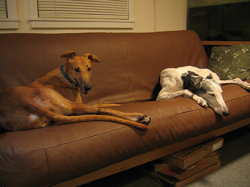

Neigbour:  3
Image classes are
dog


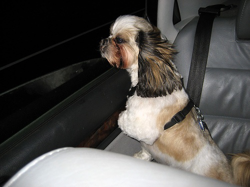

Neigbour:  4
Image classes are
dog
sofa


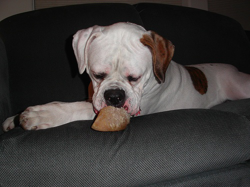

Neigbour:  5


In [3]:
# Plot the images and their neighbors.
show_image(resnet_neighbor_indices, test_loader)

### CaffeNet Neighbors


 --- NEW CLASS ---
Original Image
Image classes are
bottle
person


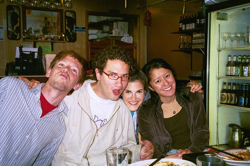

Neigbour:  1
Image classes are
bottle
person


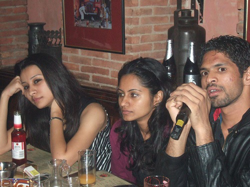

Neigbour:  2
Image classes are
person


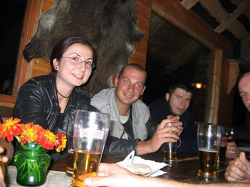

Neigbour:  3
Image classes are
chair
dog
person


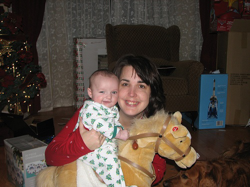

Neigbour:  4
Image classes are
person


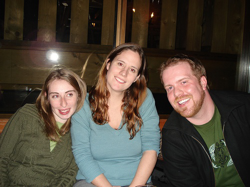

Neigbour:  5

 --- NEW CLASS ---
Original Image
Image classes are
aeroplane
bus


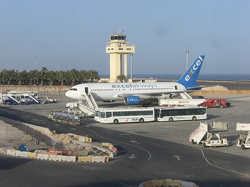

Neigbour:  1
Image classes are
aeroplane
person


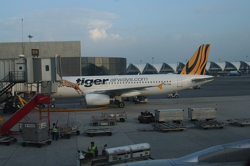

Neigbour:  2
Image classes are
boat


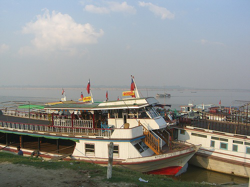

Neigbour:  3
Image classes are
aeroplane


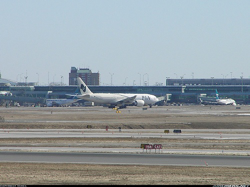

Neigbour:  4
Image classes are
boat


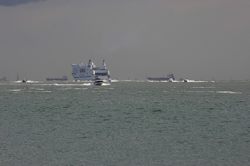

Neigbour:  5

 --- NEW CLASS ---
Original Image
Image classes are
dog


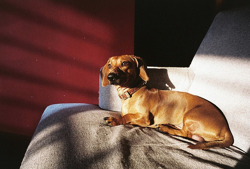

Neigbour:  1
Image classes are
person
sofa


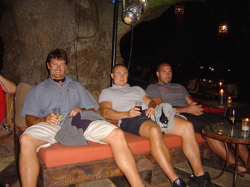

Neigbour:  2
Image classes are
bottle
diningtable
person


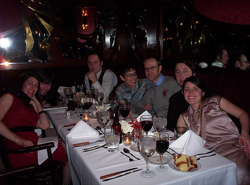

Neigbour:  3
Image classes are
person
sofa


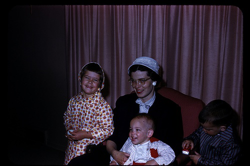

Neigbour:  4
Image classes are
chair
person
tvmonitor


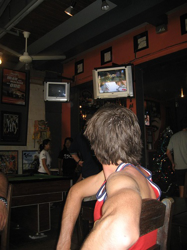

Neigbour:  5


In [4]:
show_image(caffenet_neighbor_indices, test_loader)

## 5.2 t-SNE visualization of intermediate features (7pts)
We can also visualize how the feature representations specialize for different classes. Take 1000 random images from the test set of PASCAL, and extract caffenet (scratch) fc7 features from those images. Compute a 2D [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection of the features, and plot them with each feature color coded by the GT class of the corresponding image. If multiple objects are active in that image, compute the color as the ”mean” color of the different classes active in that image. Legend the graph with the colors for each object class.

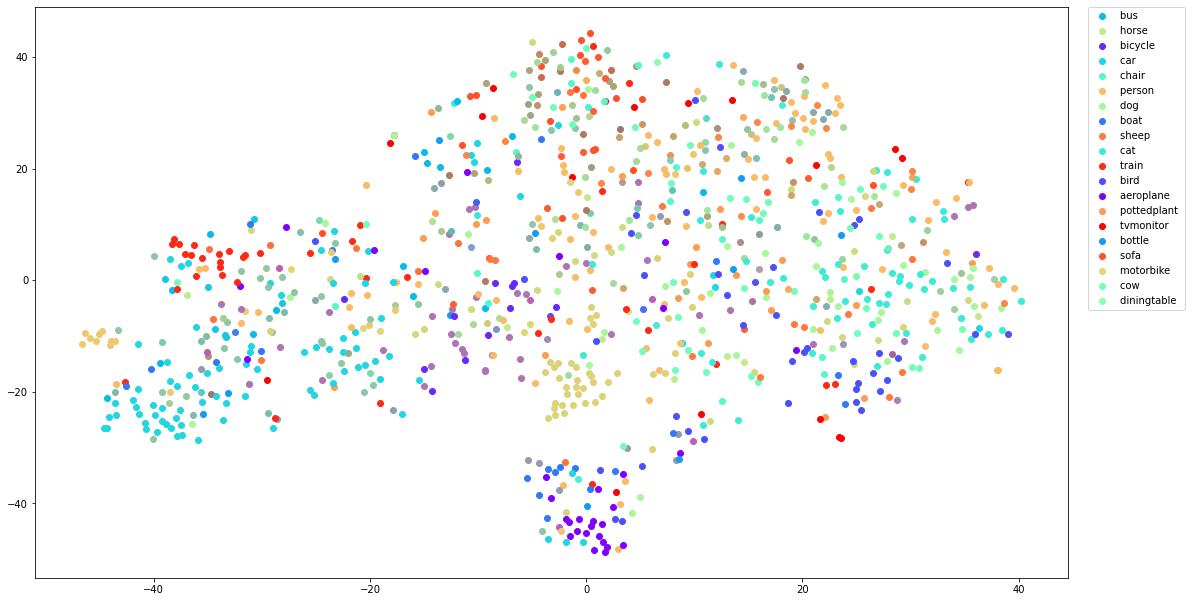

In [5]:
# plot t-SNE here
caffenet_features, label = find_caffenet_features(test_loader)
tsne_projection = TSNE(2).fit_transform(caffenet_features)
plot_features(tsne_projection, label, test_loader)

## 5.3 Are some classes harder? (6pts)
Show the per-class performance of your caffenet (scratch) and ResNet (finetuned) models. This is an open-ended question and you may use any performance metric that makes sense. Try to explain, by observing examples from the dataset, why some classes are harder or easier than the others (consider the easiest and hardest class). Do some classes see large gains due to pre-training? Can you explain why that might happen?

**YOUR ANSWER HERE**

### For Finetuned Resnet

In [4]:
test_loader = VOCDataset('test', 224)
resnet_gt, resnet_pred = test_metrics(test_loader, 'resnet')
confusion_metric_resnet = multilabel_confusion_matrix(resnet_gt, resnet_pred)
resnet_report = {}

for i, class_name in enumerate(test_loader.CLASS_NAMES):
    precision = confusion_metric_resnet[i][1][1] / (confusion_metric_resnet[i][1][1] + confusion_metric_resnet[i][1][0])
    recall = confusion_metric_resnet[i][1][1] / (confusion_metric_resnet[i][1][1] + confusion_metric_resnet[i][0][1])
    f1 = 2 * precision * recall / (precision + recall)
    resnet_report[class_name] = [precision, recall, f1]

In [5]:
resnet_precision_order = sorted(resnet_report.items(), key=lambda x: x[1][0])
resnet_recall_order = sorted(resnet_report.items(), key=lambda x: x[1][1])
resnet_f1_order = sorted(resnet_report.items(), key=lambda x: x[1][2])
for precision, recall, f1 in zip(resnet_precision_order, resnet_recall_order, resnet_f1_order):
    print(precision[0], recall[0], f1[0])

bottle bottle bottle
sheep chair sheep
pottedplant cow cow
cow tvmonitor pottedplant
diningtable sheep chair
chair sofa tvmonitor
sofa pottedplant diningtable
bus diningtable sofa
dog bus bus
tvmonitor dog dog
motorbike bird boat
cat boat motorbike
boat cat cat
bicycle car bird
bird motorbike bicycle
horse person car
train bicycle horse
car aeroplane train
aeroplane train aeroplane
person horse person


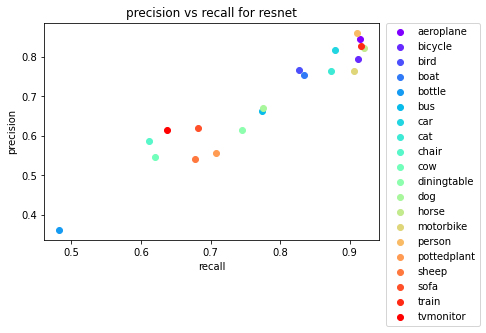

In [6]:
plot_metrics(resnet_report)

### For Caffenet scratch

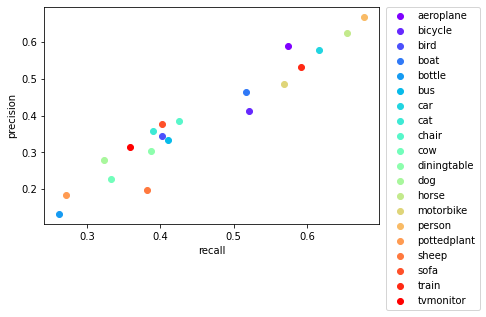

In [7]:
test_loader = VOCDataset('test', 224)
caffenet_report = {}
resnet_gt, resnet_pred = test_metrics(test_loader, 'caffenet')
confusion_metric_caffenet = multilabel_confusion_matrix(resnet_gt, resnet_pred)
for i, class_name in enumerate(test_loader.CLASS_NAMES):
    precision = confusion_metric_caffenet[i][1][1] / (confusion_metric_caffenet[i][1][1] + confusion_metric_caffenet[i][1][0])
    recall = confusion_metric_caffenet[i][1][1] / (confusion_metric_caffenet[i][1][1] + confusion_metric_caffenet[i][0][1])
    f1 = 2 * precision * recall / (precision + recall)
    caffenet_report[class_name] = [precision, recall, f1]
caffenet_report
plot_metrics(caffenet_report, False)

In [8]:
caffenet_precision_order = sorted(caffenet_report.items(), key= lambda x: x[1][0])
caffenet_recall_order = sorted(caffenet_report.items(), key=lambda x: x[1][1])
caffenet_f1_order = sorted(caffenet_report.items(), key=lambda x: x[1][2])
for precision, recall, f1 in zip(caffenet_precision_order, caffenet_recall_order, caffenet_f1_order):
    print(precision[0], recall[0], f1[0])

bottle bottle bottle
sheep pottedplant pottedplant
pottedplant dog sheep
cow cow cow
dog tvmonitor dog
diningtable sheep diningtable
tvmonitor diningtable tvmonitor
bus cat bus
bird sofa bird
cat bird cat
bicycle bus sofa
chair chair chair
sofa boat bicycle
boat bicycle boat
motorbike motorbike motorbike
train aeroplane train
car train car
horse car aeroplane
aeroplane horse horse
person person person


## Observations
#### Hardest class: Bottle
#### Easiest class: Person
From the sorted class list of both resnet and caffenet we can see that the most hard classes are bottle, sheep, cow and pottedplant. The easiest classes are person, aeroplane and train. The pretarining with resnet improves the precision of bottle from 0.1875 to 0.2625. So pretraining helps. Every class (recall, precision, f1-score) increases due to pre training. This is beacuse the imagenet has similar datas in large numbers to the pretrained model is already good in classifying these objects.

### For bottle


In [11]:
resnet_report['bottle'], caffenet_report['bottle']

([0.2875, 0.4825174825174825, 0.3603133159268929], [0.0875, 0.2625, 0.13125])

For bottle, most of the data have some other classes in them like person holding a bottle, bottle near dining table, or sofa. So the network activates the other more prominant objects in the image, thereby giving a small output for bottle class. In case of cow, dog, sheep the general features of the animals are captured making it hard to classify them.

### For person

In case of person class, the features (like edges, curvature) is very different from most other classes in the dataset. So probability of not detecting person and classyfing non-person as person is really low.

In [10]:
resnet_report['person'], caffenet_report['person']

([0.8164043872198379, 0.9106382978723404, 0.8609504651747548],
 [0.6609442060085837, 0.6774193548387096, 0.6690803765387401])